# 05- Exploratory Data Analysis on Disengaged Features

**Goal**: The goal of this notebook is to assess how best to combine (if at all) prev violation and prev trial not started features. It's specifically focused for 2024-03-07 meeting with Jonathan.


In [2]:
import pandas as pd
import numpy as np

from multiglm.features.design_matrix_generator import *
from multiglm.features.design_matrix_generator_PWM import *
from multiglm.data.dataset_loader import *

%load_ext autoreload
%autoreload 2

In [3]:
df = DatasetLoader(data_type="new_trained").load_data()

Loading data for animal ids:  ['W051', 'W060', 'W065', 'W066', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083', 'W088', 'W089', 'W094']


In [40]:
config = {
    "animal_id": lambda df: copy(df.animal_id),
    "session": lambda df: copy(df.session),
    "violation": lambda df: copy(df.violation),
    "prev_violation": lambda df: prev_violation(df),
    "prev_trial_not_started": lambda df: binarize(
        df.n_prev_trial_not_started, operator.gt, value=0
    ),
    "n_prev_not_started": lambda df: copy(df.n_prev_trial_not_started),
}

## Venn Diagram for Single Animal

In [5]:
dmg = DesignMatrixGeneratorPWM(df.query("animal_id == 'W051'"), config)
X, _ = dmg.create()

In [7]:
total_trials = len(X)
total_viol = len(X.query("violation == 1"))
p_viol_trials = len(X.query("prev_violation == 1"))
p_ns_trials = len(X.query("prev_trial_not_started == 1"))
both_trials = len(X.query("prev_violation == 1 & prev_trial_not_started == 1"))

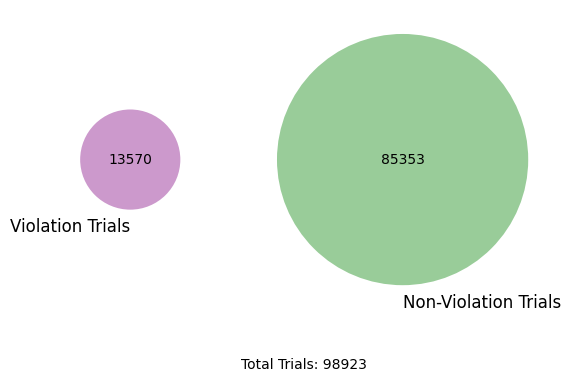

In [8]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Calculate non-violation trials
non_viol_trials = total_trials - total_viol

# Since there's no overlap (violation and non-violation are disjoint sets),
# the diagram will essentially show them as separate with no intersection.
venn2(
    subsets=(total_viol, non_viol_trials, 0),
    set_labels=("Violation Trials", "Non-Violation Trials"),
    set_colors=("purple", "green"),
)

# Optional: Annotate with total trials
plt.annotate(
    f"Total Trials: {total_trials}",
    xy=(0.5, -0.2),
    xycoords="axes fraction",
    ha="center",
)

plt.show()

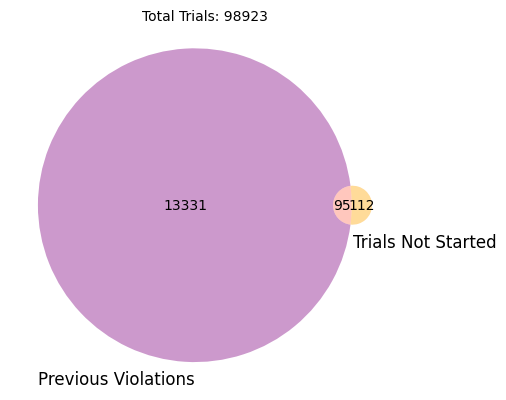

In [11]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt


# Set labels for each set
labels = {
    "10": p_viol_trials - both_trials,
    "01": p_ns_trials - both_trials,
    "11": both_trials,
}

# Create the Venn diagram
venn2(
    subsets=(labels["10"], labels["01"], labels["11"]),
    set_labels=("Previous Violations", "Trials Not Started"),
    set_colors=("purple", "orange"),
)

plt.annotate(
    f"Total Trials: {total_trials}",
    xy=(0.5, 1),
    xycoords="axes fraction",
    ha="center",
)

plt.show()

## Diagram for Each Animal

In [28]:
import pandas as pd
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
from pathlib import Path

config = {
    "animal_id": lambda df: copy(df.animal_id),
    "session": lambda df: copy(df.session),
    "violation": lambda df: copy(df.violation),
    "prev_violation": lambda df: prev_violation(df),
    "prev_trial_not_started": lambda df: binarize(
        df.n_prev_trial_not_started, operator.gt, value=0
    ),
    "n_prev_not_started": lambda df: copy(df.n_prev_trial_not_started),
}
# Initialize an empty DataFrame to store summary stats for all animals
summary_dfs = []

# Directory to save plots

plots_dir = Path("../figures/from_eda")
data_dir = Path("../data/processed/from_eda")

plots_dir.mkdir(parents=True, exist_ok=True)

for animal_id, group_df in df.groupby("animal_id"):
    # Make X for an animal
    dmg = DesignMatrixGeneratorPWM(group_df, config)
    X, _ = dmg.create()

    # Compute stats
    total_trials = len(X)
    total_viol = len(X.query("violation == 1"))
    p_viol_trials = len(X.query("prev_violation == 1"))
    p_ns_trials = len(X.query("prev_trial_not_started == 1"))
    both_trials = len(X.query("prev_violation == 1 & prev_trial_not_started == 1"))
    non_viol_trials = total_trials - total_viol

    # Plot viol vs not
    plt.figure()
    venn2(
        subsets=(total_viol, non_viol_trials, 0),
        set_labels=("Violation Trials", "Non-Violation Trials"),
        set_colors=("purple", "green"),
    )
    plt.title(f"Animal ID: {animal_id} - Violation vs Non-Violation")
    plt.annotate(
        f"Total Trials: {total_trials}",
        xy=(0.5, -0.2),
        xycoords="axes fraction",
        ha="center",
    )
    plt.savefig(plots_dir / f"05_{animal_id}_viol_vs_nonviol_venn.png")
    plt.close()

    # Plot overlapping viol/ns
    plt.figure()
    venn2(
        subsets=(p_viol_trials - both_trials, p_ns_trials - both_trials, both_trials),
        set_labels=("Previous Violations", "Prev Trials Not Started"),
        set_colors=("purple", "orange"),
    )
    plt.title(f"Animal ID: {animal_id} - Violation & Trials Not Started")
    plt.savefig(plots_dir / f"05_{animal_id}_viol_and_ns_venn.png")
    plt.close()

    new_row = pd.DataFrame(
        {
            "animal_id": [animal_id],
            "n_prev_viol": [p_viol_trials],
            "n_prev_timeout": [p_ns_trials],
            "both": [both_trials],
            "total_trials": [total_trials],
        }
    )

    summary_dfs.append(new_row)

# Save the summary DataFrame
summary_df = pd.concat(summary_dfs, ignore_index=True)
summary_df.to_csv(data_dir / "05_venn_summary_stats.csv", index=False)

In [29]:
summary_df

,animal_id,n_prev_viol,n_prev_timeout,both,total_trials
0,W051,13426,207,95,98923
1,W060,11051,768,268,81806
2,W065,20197,877,610,79634
3,W066,29875,162,61,116580
4,W068,17714,999,327,113316
5,W072,14206,1317,520,91069
6,W073,16270,858,315,126023
7,W074,22261,732,365,237512
8,W075,39513,560,170,235945
9,W078,8146,633,228,80582


## Summary weighted average

In [31]:
summary_df

,animal_id,n_prev_viol,n_prev_timeout,both,total_trials
0,W051,13426,207,95,98923
1,W060,11051,768,268,81806
2,W065,20197,877,610,79634
3,W066,29875,162,61,116580
4,W068,17714,999,327,113316
5,W072,14206,1317,520,91069
6,W073,16270,858,315,126023
7,W074,22261,732,365,237512
8,W075,39513,560,170,235945
9,W078,8146,633,228,80582


In [32]:
weighted_sum_viol = (summary_df["n_prev_viol"] * summary_df["total_trials"]).sum()
weighted_sum_timeout = (summary_df["n_prev_timeout"] * summary_df["total_trials"]).sum()
weighted_sum_both = (summary_df["both"] * summary_df["total_trials"]).sum()

# Calculate the total of all trials
total_weight = summary_df["total_trials"].sum()

# Calculate weighted averages
weighted_avg_viol = weighted_sum_viol / total_weight
weighted_avg_timeout = weighted_sum_timeout / total_weight
weighted_avg_both = weighted_sum_both / total_weight

# Calculate the unique counts for the Venn diagram
unique_viol = weighted_avg_viol - weighted_avg_both
unique_timeout = weighted_avg_timeout - weighted_avg_both

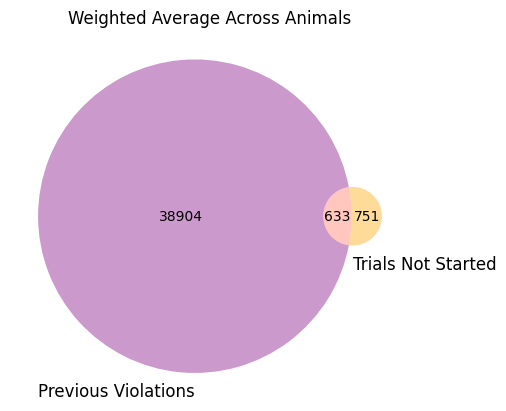

In [39]:
# Plotting the weighted average Venn diagram
plt.figure()
venn2(
    subsets=(int(unique_viol), int(unique_timeout), int(weighted_avg_both)),
    set_labels=("Previous Violations", "Trials Not Started"),
    set_colors=("purple", "orange"),
)

plt.title("Weighted Average Across Animals")
plt.show()

Not sure if weighted average is the best thing to do here (maybe percents would be better?), but I think this get's the point across. There are very few not started trials. However, it appears that half about half the not started trials come after a violation. This can be thought through in the table below in the "cleaned df" where trial 3 has both a previous violation and previous trial not started. 

An additional plot that would be worth looking at is:
* time out rate rate following a violation versus not a violation

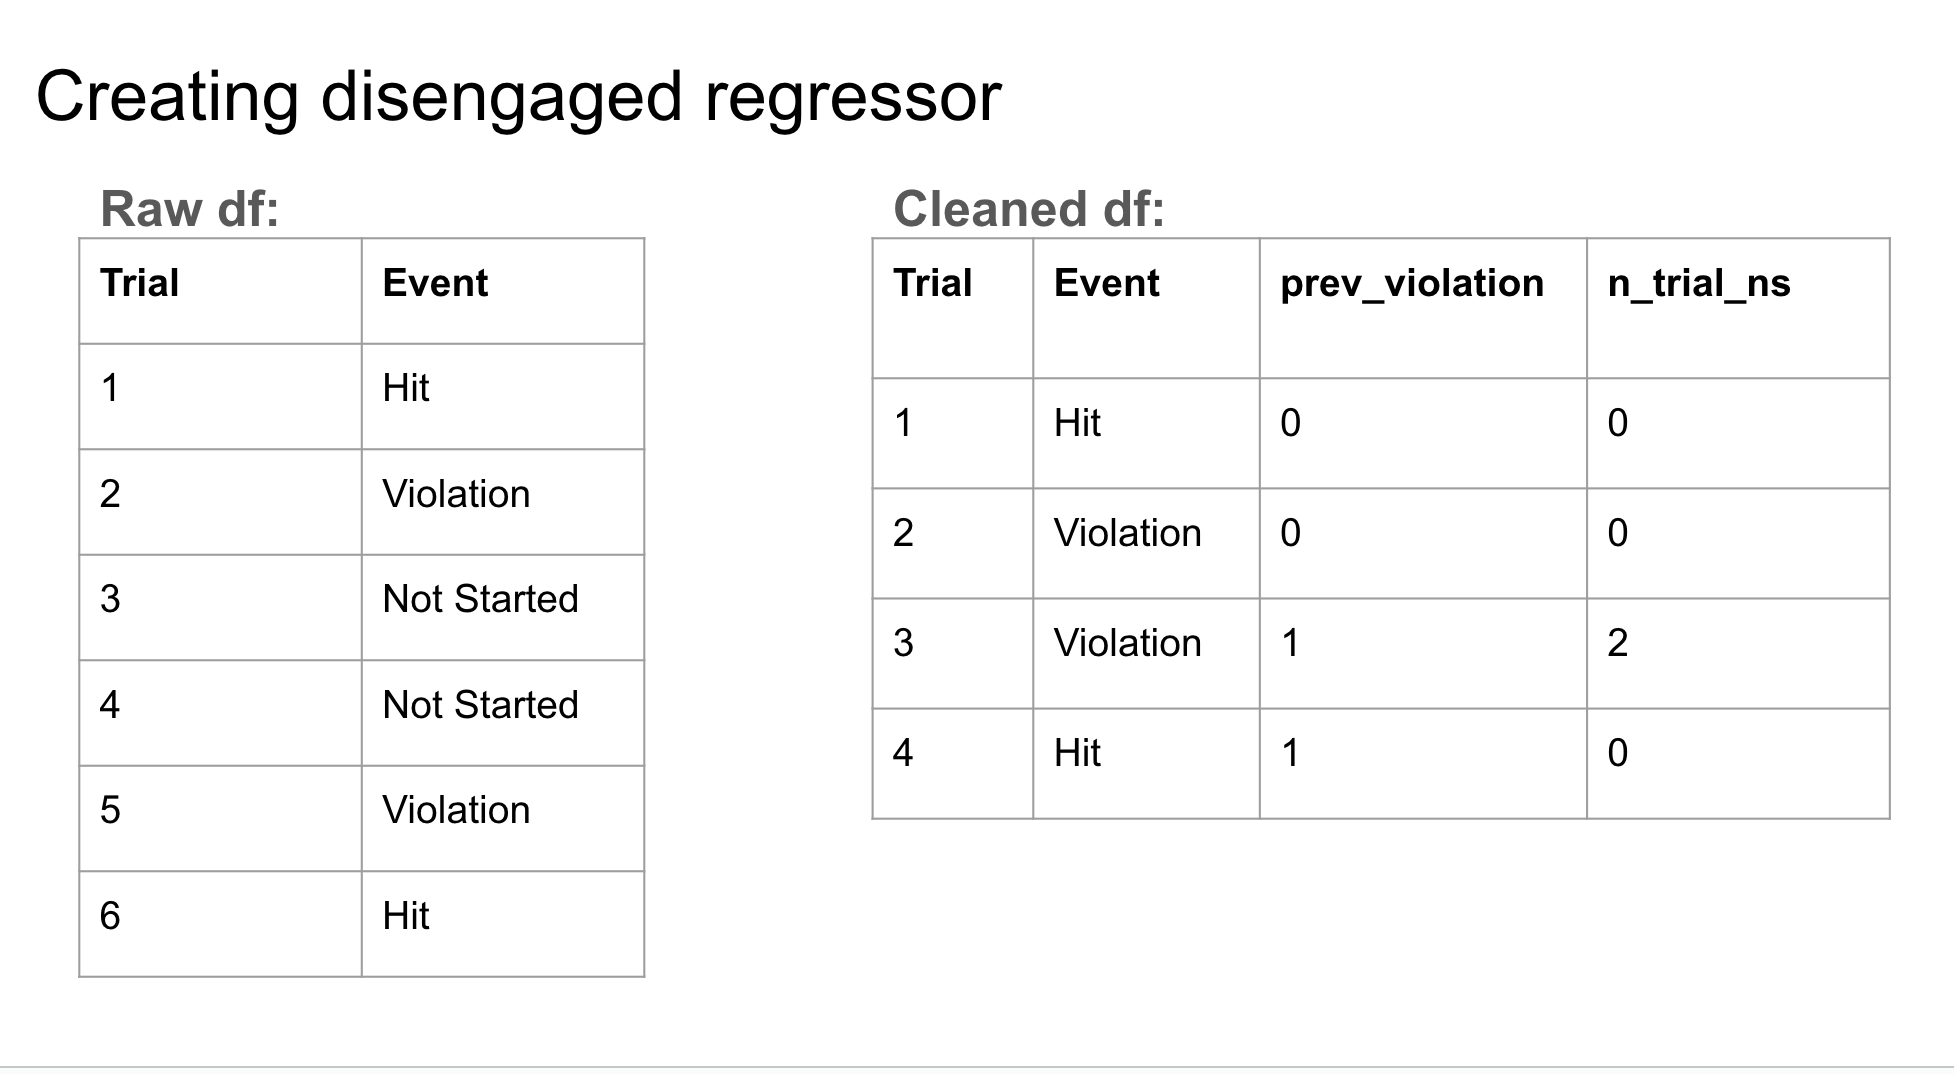

In [57]:
config = {
    "animal_id": lambda df: copy(df.animal_id),
    "session": lambda df: copy(df.session),
    "prev_violation": lambda df: prev_violation(df),
    "prev_trial_not_started": lambda df: binarize(
        df.n_prev_trial_not_started, operator.gt, value=0
    ),
    "n_prev_not_started": lambda df: copy(df.n_prev_trial_not_started),
}


all_animal_Xs = []
for animal_id, group_df in df.groupby("animal_id"):
    dmg = DesignMatrixGeneratorPWM(group_df, config)
    X, _ = dmg.create()

    all_animal_Xs.append(X)

all_animals_df = pd.concat(all_animal_Xs, ignore_index=True)

In [66]:
all_animals_df

,choice,animal_id,session,prev_violation,prev_trial_not_started,n_prev_not_started
0,2,W051,326,0,0,0.0
1,2,W051,326,1,0,0.0
2,2,W051,326,1,0,0.0
3,0,W051,326,1,0,0.0
4,1,W051,326,0,0,0.0
...,...,...,...,...,...,...
2144770,2,W094,526,1,0,0.0
2144771,2,W094,526,1,0,0.0
2144772,0,W094,526,1,0,0.0
2144773,1,W094,526,0,0,0.0


In [78]:
pre_post_viol_timeout_df = (
    all_animals_df.groupby(["animal_id", "session", "prev_violation"])
    .agg({"prev_trial_not_started": "mean", "n_prev_not_started": "mean"})
    .reset_index()
    .groupby(["animal_id", "prev_violation"])
    .agg({"prev_trial_not_started": "mean", "n_prev_not_started": "mean"})
    .reset_index()
)

pre_post_viol_timeout_df.head(5)

,animal_id,prev_violation,prev_trial_not_started,n_prev_not_started
0,W051,0,0.009853,0.032094
1,W051,1,0.017318,0.101061
2,W060,0,0.007819,0.030142
3,W060,1,0.024751,0.125832
4,W065,0,0.004859,0.011223


In [84]:
wide_ns_rates = pre_post_viol_timeout_df.pivot(
    index="animal_id", columns="prev_violation", values="prev_trial_not_started"
)

wide_ns_rates.columns = ["ns_rate_no_prev_viol", "ns_rate_with_prev_viol"]

wide_ns_rates.reset_index(inplace=True)

wide_ns_rates.to_csv(
    "../data/processed/from_eda/05_post_viol_ts_rates.csv", index=False
)

wide_ns_rates.head()

,animal_id,ns_rate_no_prev_viol,ns_rate_with_prev_viol
0,W051,0.009853,0.017318
1,W060,0.007819,0.024751
2,W065,0.004859,0.036757
3,W066,0.001556,0.002969
4,W068,0.012514,0.026672


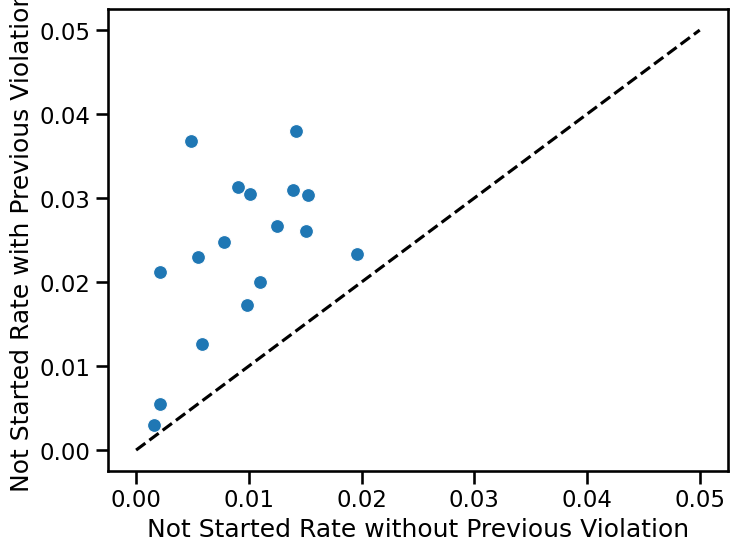

In [92]:
limits = (0, 0.05)
# Scatter plot
import seaborn as sns

sns.set_context("talk")

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=wide_ns_rates, x="ns_rate_no_prev_viol", y="ns_rate_with_prev_viol", s=100
)

plt.plot(limits, limits, "k--", label="Unity Line")

plt.xlabel("Not Started Rate without Previous Violation")
plt.ylabel("Not Started Rate with Previous Violation")

plt.show()

In [93]:
wide_ns_avg_counts = pre_post_viol_timeout_df.pivot(
    index="animal_id", columns="prev_violation", values="n_prev_not_started"
)

wide_ns_avg_counts.columns = ["avg_n_ns_no_prev_viol", "avg_n_ns_with_prev_viol"]

wide_ns_avg_counts.reset_index(inplace=True)

wide_ns_avg_counts.to_csv(
    "../data/processed/from_eda/05_post_viol_ts_avg_counts.csv", index=False
)

wide_ns_avg_counts.head()

,animal_id,avg_n_ns_no_prev_viol,avg_n_ns_with_prev_viol
0,W051,0.032094,0.101061
1,W060,0.030142,0.125832
2,W065,0.011223,0.101395
3,W066,0.002328,0.008889
4,W068,0.058196,0.209241


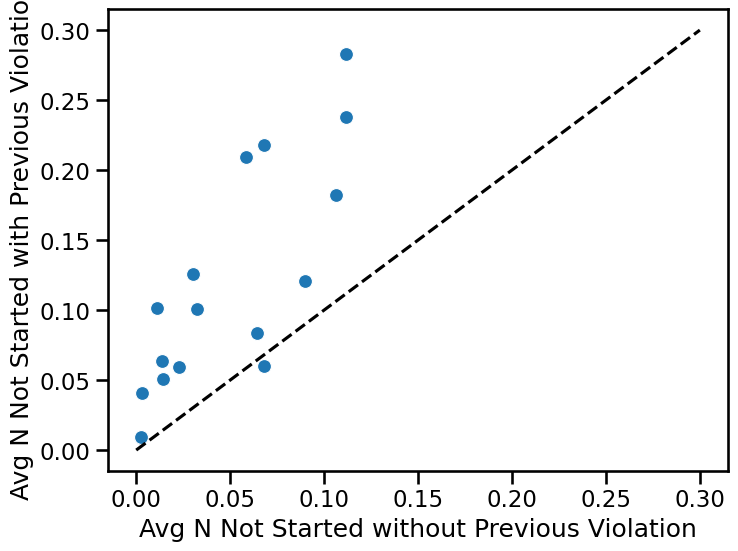

In [98]:
limits = (0, 0.3)
# Scatter plot


plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=wide_ns_avg_counts,
    x="avg_n_ns_no_prev_viol",
    y="avg_n_ns_with_prev_viol",
    s=100,
)

plt.plot(limits, limits, "k--", label="Unity Line")

plt.xlabel("Avg N Not Started without Previous Violation")
plt.ylabel("Avg N Not Started with Previous Violation")

plt.show()

This is pretty cool- really makes me want to think avg iti pre and post violation trial. As opposed to just "was it long". Time would be an interesting regressor.